In [49]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import gc

In [57]:
# ALL CONSTANTS STORED IN THIS CELL

# DIMENSIONS
GRID_ROWS = 150
GRID_COLS = 150

# S = Total susceptible per cell i, j
# I = Total infected per cell i, j
# R = Total removed per cell i, j
# N = total pop per cell i, j (S[i][j] + I[i][j] + R[i][j] = N[i][j])
S, I, R, N = [], [], [], []

INFECTION_POINTS = [(int(np.random.random_sample() * GRID_ROWS), 
                    (int(np.random.random_sample() * GRID_COLS)))
                    for i in range(2)]

START_INFECTION_POINTS = INFECTION_POINTS[:]

# sum of all persons in every cell Sigma(N[i][j]) for all i,j
EXPECTED_POPULATION = 1000000

# This is to be set after the gaussian step
TOTAL_POPULATION = None

# Maximum number of days to simulate
MAX_DAYS = 40

# Transmission rate in persons/time
# the number was estimated from looking at global data for the number of daily cases
# https://www.worldometers.info/coronavirus/coronavirus-cases/#daily-cases
BETA = 4 / 9

# Recovery rate (estimated as 1/(mean infectious period (onset of symptoms until death or recovery))
# the number here is taken from https://en.wikipedia.org/wiki/Coronavirus_disease_2019#Prognosis
GAMMA = 1.0 / 9

# mu = mean to re-center the gaussian
mu = (GRID_ROWS/2 + GRID_COLS/2)/2

# sigma = std. dev. (must be large to get full spread over the grid)
sigma = 60

In [58]:
# All equations and simulations stored in this cell

# normalized 2d gaussian function 
def multi_gaussian(row, col, mu1, mu2, s):
    return np.exp(-((col-mu2)**2 +(row-mu1)**2)/(2*s*s))/(s**2*2*np.pi)

# 1st order non-linear DiffEQs based on the SIR model
#https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-the-differential-equation-model
def s_prime(s, i, n):
    return -1.0 * min(s, BETA * i * s / n)

def i_prime(s, i , n):
    return min(s, BETA * i * s / n)

def r_prime(i):
    return min(i, GAMMA * i)

# Next three equations use Euler's method to compute new population sizes
def euler_s(s, i, n):
    """
    Euler's method, subtract from current pop the rate of change of susceptible pop
    see diffEQ link above
    :param s: susceptible pop
    :param i: infected pop
    :param n: total pop
    :return: new population
    """
    return s  + s_prime(s, i, n)

def euler_i(s, i, n):
    return  i + i_prime(s, i, n) - r_prime(i)

def euler_r(r, i):
    return r + r_prime(i)

# vectorize the euler method funcs to optimize for speed
vec_s = np.vectorize(euler_s)
vec_i = np.vectorize(euler_i)
vec_r = np.vectorize(euler_r)

# simulates a spread of infection via BFS
def BFS():
    """
    uses breadth first search to spread infection to neighboring cells
    rooted at the initial infection points (see INFECTION_POINTS above)
    """
    # init q to the first infection points
    q = INFECTION_POINTS[:]
    # memoize visited cells
    visit = np.zeros((GRID_ROWS, GRID_COLS))
    for p in INFECTION_POINTS:
        visit[p[0]][p[1]] = 1
    while q:
        n = len(q)
        for i in range(n):
            top = q[0]
            r, c = top[0], top[1]
            q.pop(0)
            for rr in [-1,0,1]:
                for cc in [-1,0,1]:
                    if rr == 0 and cc == 0:
                        continue
                    dr = r + rr
                    dc = c + cc
                    if 0 <= dr < GRID_ROWS and 0 <= dc < GRID_COLS and visit[dr][dc] == 0:
                        # compute the new susceptibility taken directly from suscept. eq.
                        # divide by 8 to take a weighted average (8 neighbors)
                        new_infected = i_prime(S[dr][dc], I[r][c]/8, N[dr][dc])
                        S[dr][dc] = max(0, S[dr][dc] - new_infected)
                        I[dr][dc] = min(N[dr][dc], I[dr][dc] + new_infected)
                        q.append((dr, dc))
                        if (dr, dc) not in INFECTION_POINTS:
                            INFECTION_POINTS.append((dr, dc))
                        visit[dr][dc] = 1

# initializes populations
def init():
    s_temp = np.zeros((GRID_ROWS,GRID_COLS))
    i_temp = np.zeros((GRID_ROWS,GRID_COLS))
    r_temp = np.zeros((GRID_ROWS,GRID_COLS))
    n_temp = np.zeros((GRID_ROWS,GRID_COLS))
    
    # initialize the starting populations of each cell 
    for r in range(GRID_ROWS):
        for c in range(GRID_COLS):
            n_temp[r][c] = multi_gaussian(r, c, mu, mu, sigma)
            n_temp[r][c] = n_temp[r][c] * EXPECTED_POPULATION
            s_temp[r][c] = n_temp[r][c]
            
    # assuming the simulation has been run, this needs to be cleared 
    # before running again
    INFECTION_POINTS.clear()
    # Initialize infected cells
    for p in START_INFECTION_POINTS:
        row, col = p[0], p[1]
        INFECTION_POINTS.append((row, col))
        init_infected = n_temp[row][col] * np.random.random_sample()
        i_temp[row][col] += init_infected
        s_temp[row][col] -= init_infected
    return s_temp, i_temp, r_temp, n_temp

# runs the simulation 
def run(S, I, R, N):
    t = 0
    # loop until all recovered
    while t < MAX_DAYS:
        # use BFS to let the disease spread to its neighboring cells
        BFS()
        
        # Use Euler's method to determine new populations for current day
        S_temp = vec_s(S, I, N)
        I_temp = vec_i(S, I, N)
        R_temp = vec_r(R, I)
        
        # reassign the newly computed results to the original references
        S = S_temp
        I = I_temp
        R = R_temp
        
        # add cumulative sums to the list
        plot_s.append(np.sum(S)/TOTAL_POPULATION)
        plot_i.append(np.sum(I)/TOTAL_POPULATION)
        plot_r.append(np.sum(R)/TOTAL_POPULATION)
        if t % 10 == 0:
            infected_heatmap.append(I)
        gc.collect()
        t += 1
    return plot_s, plot_i, plot_r

# This Cell class is used for the gaussian spreading simulation.
# Each cell creates a list of 8 neighbor cells
# selected randomly by a 2D gaussian distrib.
class Cell:
    def __init__(self, row, col):
        self._coord = (row, col)
        self.neighbors = self._get_neigh()
    
    def _get_neigh(self):
        r , c = self._coord[0], self._coord[1]
        neigh = []
        while len(neigh) < 8 :
            dr = int(np.random.normal(r, 10))
            while dr < 0 or dr >= GRID_ROWS: 
                dr = int(np.random.normal(r, 10))
            dc = int(np.random.normal(c, 10))
            while dc < 0 or dc >= GRID_COLS: 
                dc = int(np.random.normal(c, 10))
            neigh.append((dr, dc))
        return neigh
    

In [59]:
# init all grids
S, I, R, N = init()

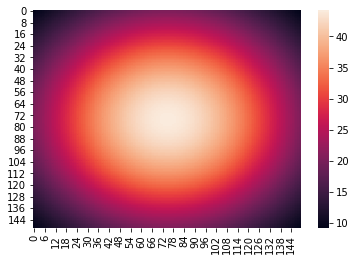

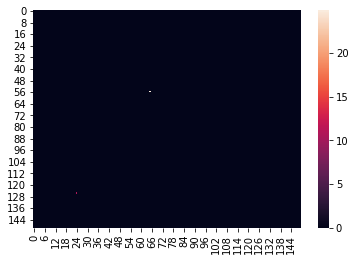

In [60]:
# display total pop. distribution
sb.heatmap(N)
plt.savefig("population_dist.png")
plt.show()
# set the true total population
TOTAL_POPULATION = np.sum(N)
# display infected cells
sb.heatmap(I)
plt.savefig("infected_cells.png")
plt.show()


In [61]:
# for each cell, create a list of 8 inter-cell neighbors selected randomly by 2D Gaussian 
mobility_matrix = [[Cell(r, c) for c in range(GRID_COLS)] for r in range(GRID_ROWS)]

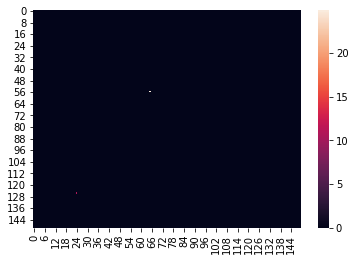

In [62]:
# set the true total population
TOTAL_POPULATION = np.sum(N)
# display initial infected cells
sb.heatmap(I)
plt.show()

In [63]:
# run using the random gaussian model
t = 0
plot_s = []
plot_i = []
plot_r = []
infected_heatmap = []
BETA = 4/9
while t < MAX_DAYS:

    ST = np.copy(S)
    IT = np.copy(I)
    RT = np.copy(R)
    
    for row in range(GRID_ROWS):
        for col in range(GRID_COLS):
            for neigh in mobility_matrix[row][col].neighbors:
                dr, dc = neigh[0], neigh[1]
                new_infected = i_prime(S[dr][dc], I[row][col]/8, N[dr][dc])
                ST[dr][dc] = max(0, ST[dr][dc] - new_infected)
                IT[dr][dc] = min(N[dr][dc], IT[dr][dc] + new_infected)
    
    # Use Euler's method to determine new populations for current day
    S = vec_s(ST, IT, N)
    I = vec_i(ST, IT, N)
    R = vec_r(RT, IT)
    
    # add cumulative sums to the list
    plot_s.append(np.sum(S)/TOTAL_POPULATION)
    plot_i.append(np.sum(I)/TOTAL_POPULATION)
    plot_r.append(np.sum(R)/TOTAL_POPULATION)
    if (t % 5 == 0):
        infected_heatmap.append(I)
    
    gc.collect()
    t += 1

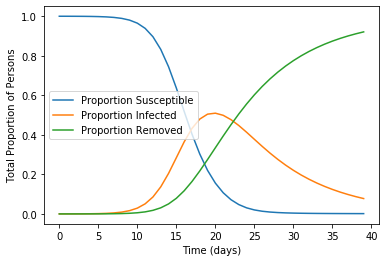

In [64]:
# Plot cum. S, I, R plots
plt.plot([t for t in range(MAX_DAYS)], plot_s, label='Proportion Susceptible')
plt.plot([t for t in range(MAX_DAYS)], plot_i, label='Proportion Infected')
plt.plot([t for t in range(MAX_DAYS)], plot_r, label='Proportion Removed')
plt.xlabel('Time (days)')
plt.ylabel('Total Proportion of Persons')
plt.legend()
plt.savefig("gaussian_spread/gauss_plot.png")
plt.show()

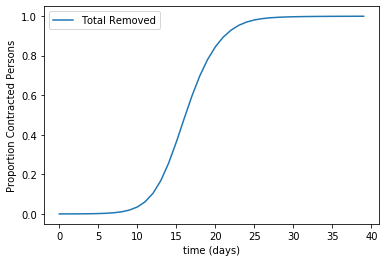

In [65]:
# Plot total number of infected + removed
cum_quarantine = [plot_i[i] + plot_r[i] for i in range(MAX_DAYS)]
plt.plot([t for t in range(MAX_DAYS)], cum_quarantine, label='Total Removed')
plt.xlabel('time (days)')
plt.ylabel('Proportion Contracted Persons')
plt.legend()
plt.show()


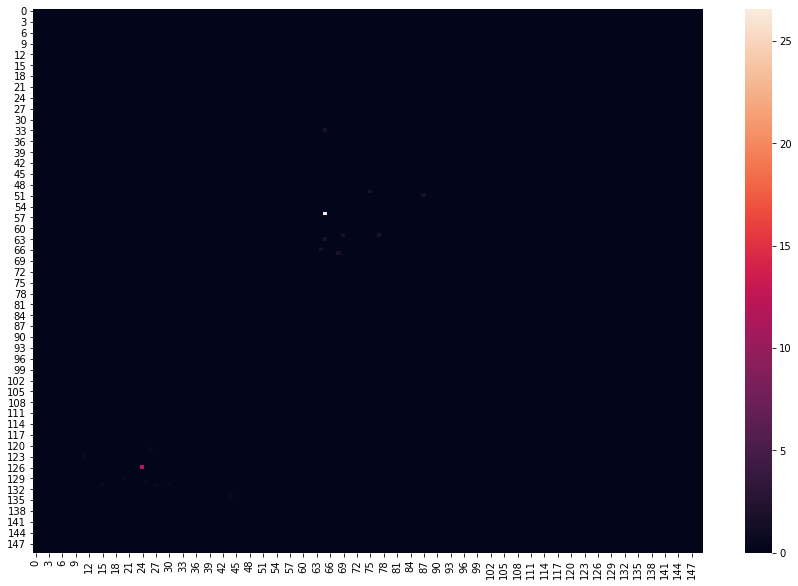

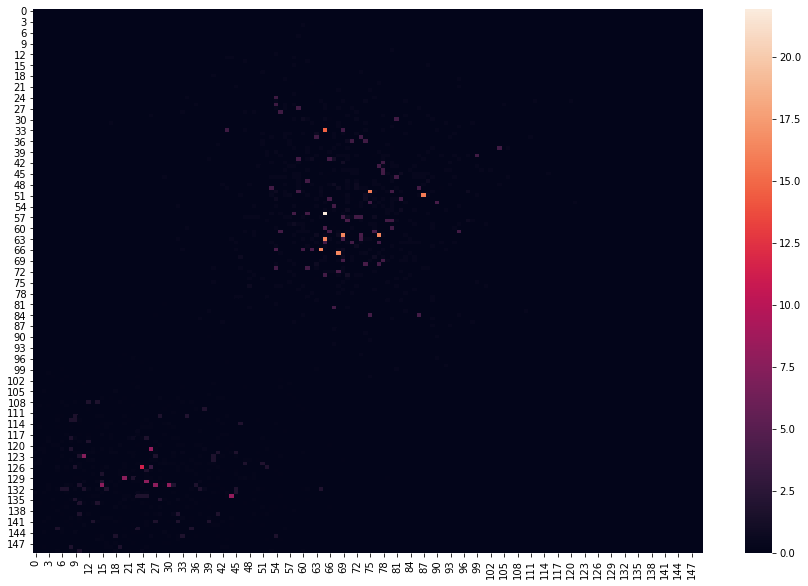

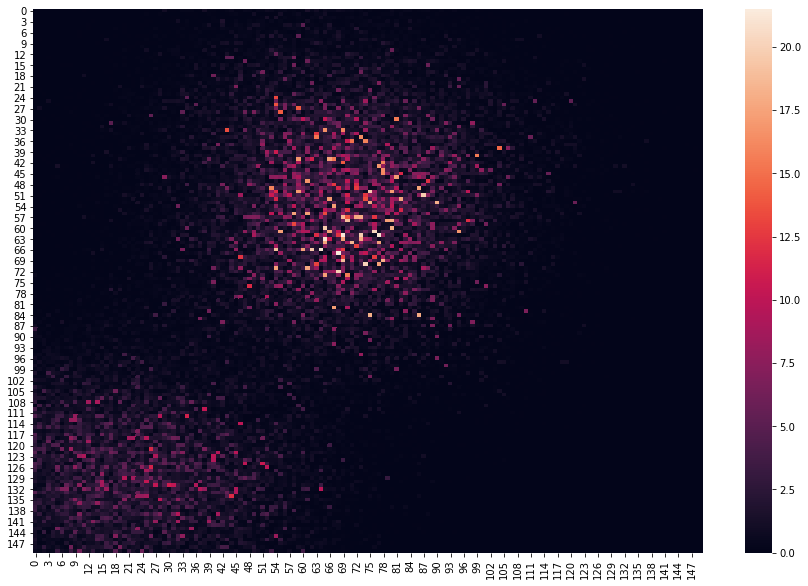

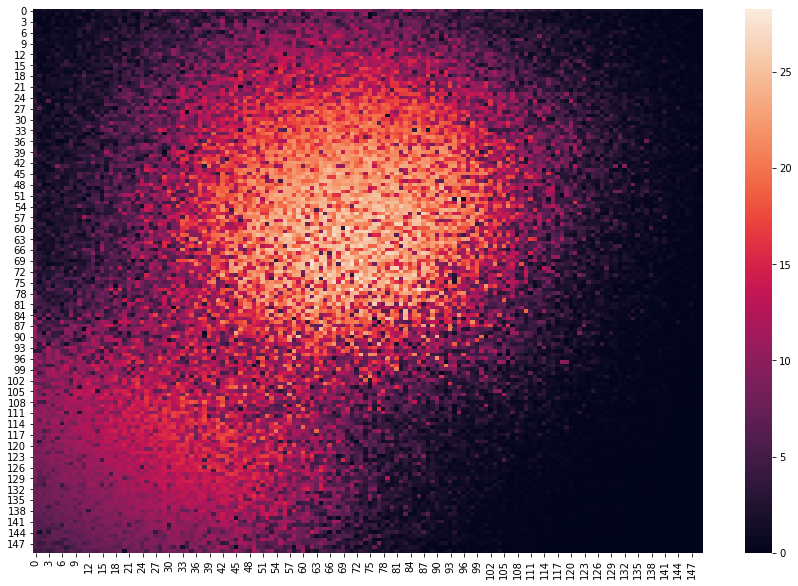

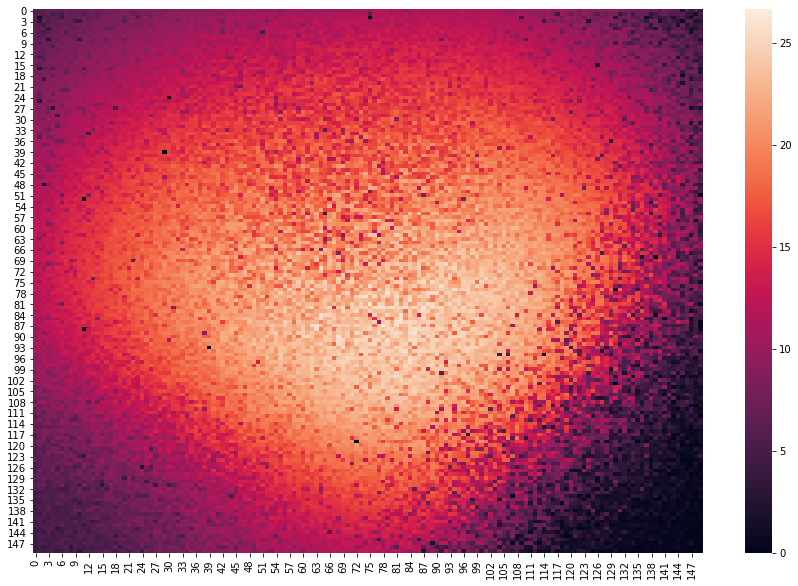

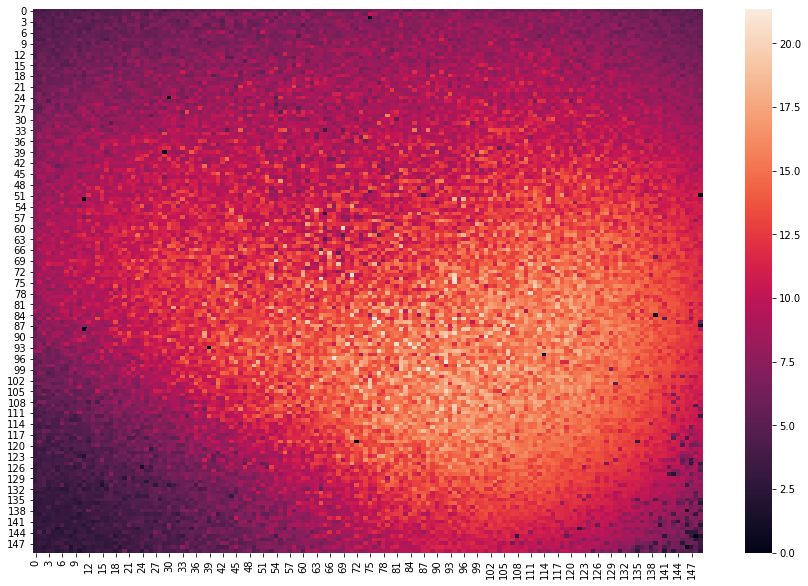

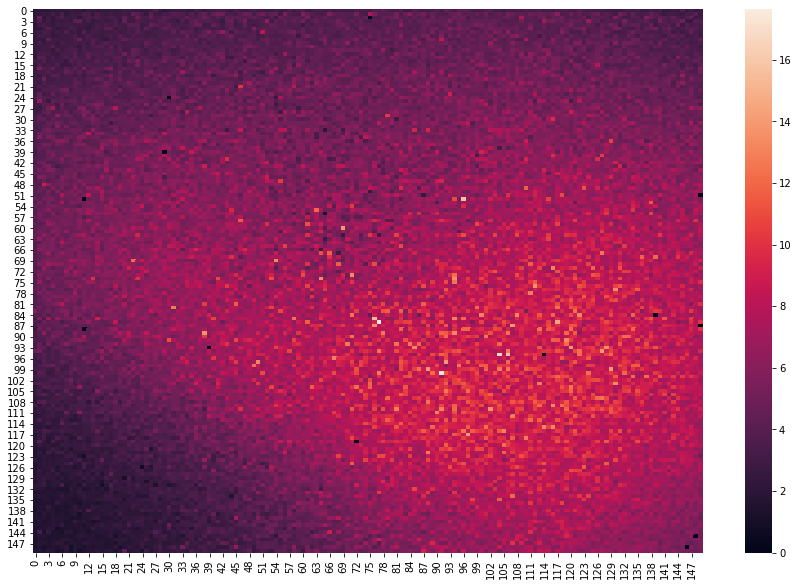

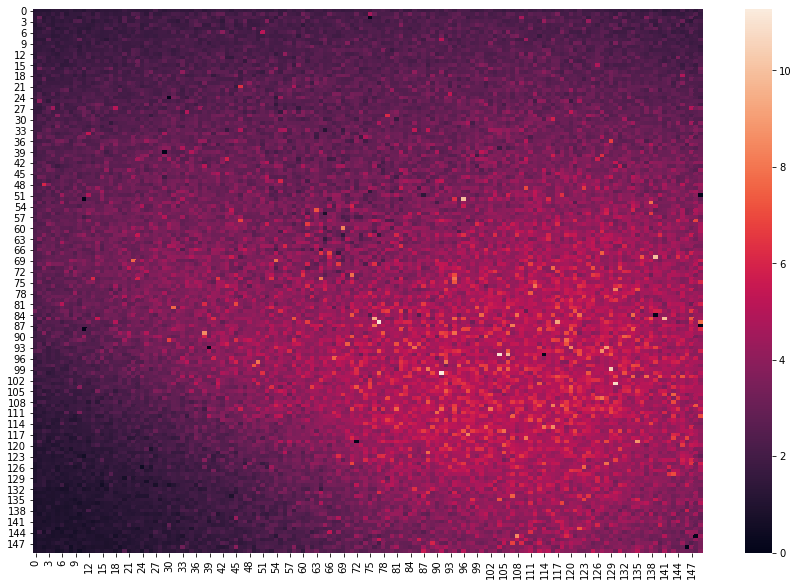

In [66]:
# Plot heatmaps showing the progression of the virus
for i in range(len(infected_heatmap)):
    plt.figure(figsize=(15, 10))
    sb.heatmap(infected_heatmap[i])
    plt.savefig("gaussian_spread/gaussian_spread_" + str(i) + ".png")
plt.show()

In [67]:
# re-initialize grids to prepare for next run
S, I, R, N = init()

In [68]:
# Run the simulation (2nd time)
# let t represent the total number of days elapsed
t = 0
# lists to store the populations for each day
plot_s = []
plot_i = []
plot_r = []
infected_heatmap = []
BETA = 4/9
plot_s, plot_i, plot_r = run(S, I, R, N)

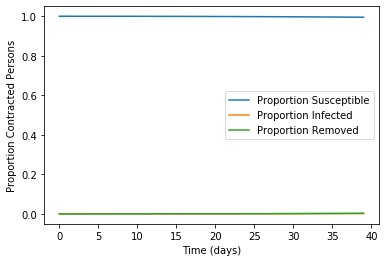

In [69]:
# Plot cum. S, I, R plots
plt.plot([t for t in range(MAX_DAYS)], plot_s, label='Proportion Susceptible')
plt.plot([t for t in range(MAX_DAYS)], plot_i, label='Proportion Infected')
plt.plot([t for t in range(MAX_DAYS)], plot_r, label='Proportion Removed')
plt.xlabel('Time (days)')
plt.ylabel('Proportion Contracted Persons')
plt.legend()
plt.savefig("no_quarantine/no_quarantine_plt.png")
plt.show()

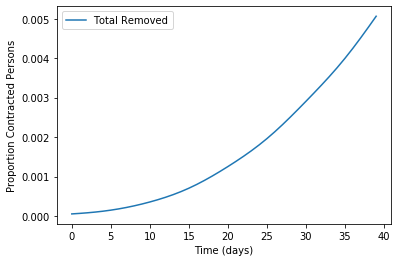

In [70]:
# Plot total number of infected + removed
cum_BFS = [plot_i[i] + plot_r[i] for i in range(MAX_DAYS)]
plt.plot([t for t in range(MAX_DAYS)], cum_BFS, label='Total Removed')
plt.xlabel('Time (days)')
plt.ylabel('Proportion Contracted Persons')
plt.legend()
plt.savefig("no_quarantine/no_quarantine_total_removed_plt.png")
plt.show()

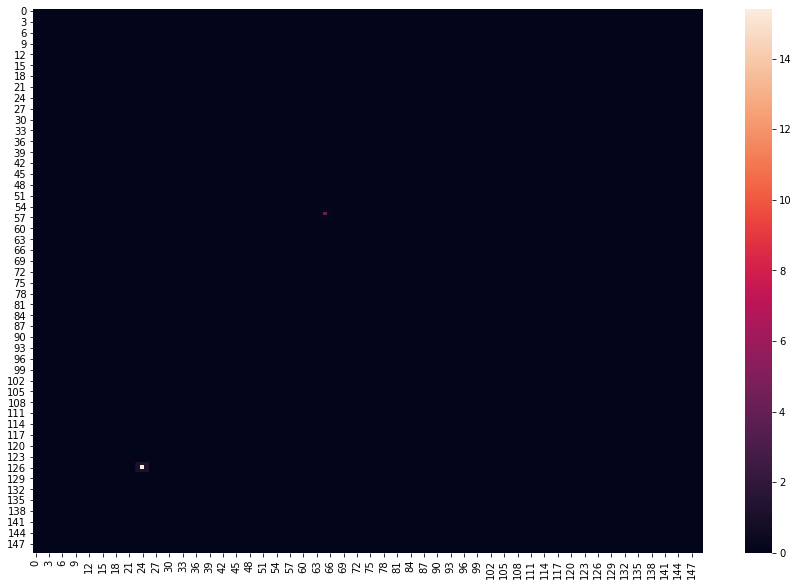

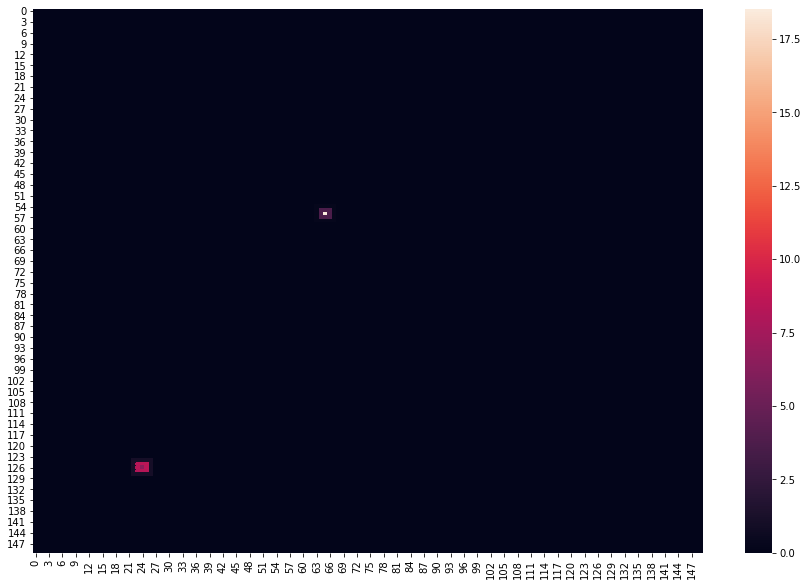

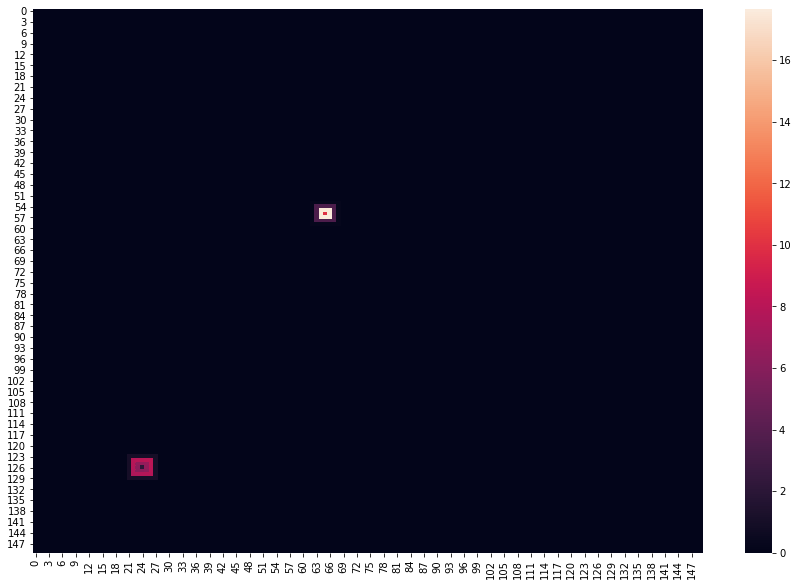

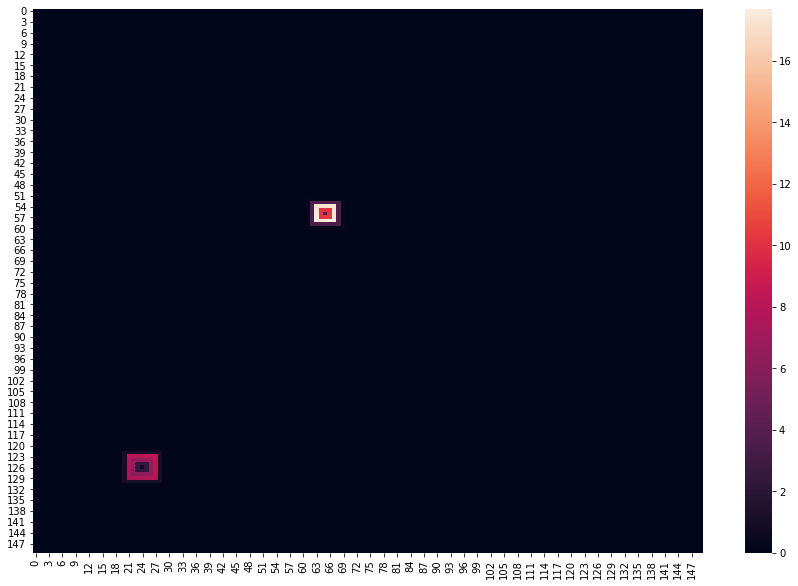

In [71]:
# Plot heatmaps showing the progression of the virus every 10 days
for i in range(len(infected_heatmap)):
    plt.figure(figsize=(15, 10))
    sb.heatmap(infected_heatmap[i])
    plt.savefig("no_quarantine/no_quarantine_heatmap_" + str(i) + ".png")
plt.show()

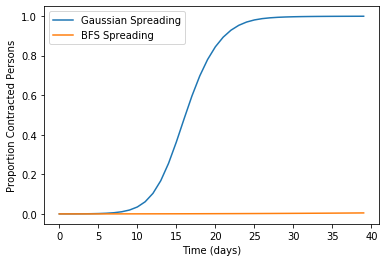

In [72]:
plt.plot([t for t in range(MAX_DAYS)], cum_quarantine, label='Gaussian Spreading')
plt.plot([t for t in range(MAX_DAYS)], cum_BFS, label='BFS Spreading')
plt.xlabel('Time (days)')
plt.ylabel('Proportion Contracted Persons')
plt.legend()
plt.savefig("combined_spread.png")
plt.show()